In [1]:
import pyOSC3
import time
import random
import copy
from collections import namedtuple, defaultdict
from subprocess import Popen
import numpy as np
import math
import json

In [2]:
client = pyOSC3.OSCClient()
client.connect(('127.0.0.1', 57120))

In [3]:
OCTAVE_IN_CENTS = 1200

def calc_hz(pitch, ref_hz):
    if pitch is None:
        return None
    return ref_hz * (2 ** (pitch / OCTAVE_IN_CENTS))

def cents_from_hz(hz, ref_hz):
    return math.log(hz / ref_hz) / math.log(2) * OCTAVE_IN_CENTS

def ratio_to_cents(m, n):
    return OCTAVE_IN_CENTS * math.log2(float(m) / n)

Chord = namedtuple('Chord', ['timestamp', 'gvm', 'tony', 'redux', 'syllable'])


In [5]:
def ch(interval_chord):
    pitches = []
    ref = None
    for cents in interval_chord:
        if cents is None:
            pitches.append(None)
            continue
        if ref is None:
            ref = cents
            pitch = ref
        else:
            pitch = ref + cents
        pitches.append(pitch)
    return pitches

def hz2c(chord_in_hz, ref_hz=55):
    chord_in_cents = []
    for hz in chord_in_hz:
        if hz is None:
            chord_in_cents.append(None)
        else:
            chord_in_cents.append(round(cents_from_hz(hz, ref_hz)))
    return chord_in_cents

def check_chords(chords, redux_cents):
    for chord in chords:
        assert(len(chord.gvm) == len(chord.tony))
        assert(len(chord.gvm) == len(chord.redux))
        for i in range(len(chord.gvm)):
            if chord.gvm[i] is None:
                assert(chord.tony[i] is None)
                assert(chord.redux[i] is None)
            elif chord.redux[i] is not None:
                if chord.redux[i] not in redux_cents:
                    print(chord.redux[i], chord)
                assert(chord.redux[i] in redux_cents)
    return True

chords = []

redux_cents = \
    [1507, 1679, 1781, 1851, 1902, 2004,
     2055, 2106, 2208, 2227, 2259, 2329, 2380, 2399,
     2431, 2482, 2501, 2552, 2584, 2603, 2622, 2654, 2673,
     2724, 2756, 2775, 2877]
# description of redux system:
# basic intervals: 102, 153, 172
# we also use equality: 102*3 = 153*2
# 1507 = 2055 - 102*2       - 172*2
# 1679 = 2055 - 102*2       - 172
# 1781 = 2055 - 102         - 172
# 1851 = 2055 - 102*2
# 2004 = 2055 + 102   - 153
# 2055
# 2106 = 2055 - 102   + 153
# 2208 = 2055         + 153
# 2227 = 2055               + 172
# 2259 = 2055 + 102*2
# 2329 = 2055 + 102         + 172
# 2380 = 2055         + 153 + 172
# 2399 = 2055               + 172*2
# 2431 = 2055 + 102*2       + 172
# 2482 = 2055 + 102   + 153 + 172
# 2501 = 2055 + 102         + 172*2
# 2552 = 2055         + 153 + 172*2
# 2584 = 2055 + 102*2 + 153 + 172
# 2603 = 2055 + 102*2       + 172*2
# 2622 = 2055 - 102   + 153 + 172*3
# 2654 = 2055 + 102   + 153 + 172*2
# 2724 = 2055         + 153 + 172*3
# 2756 = 2055 + 102*2 + 153 + 172*2
# 2775 = 2055 + 102*2       + 172*3
# 2877 = 2055 + 102*3       + 172*3

chords.append(Chord(0.78, ch([None, 2727, None]), hz2c([None, 265.9, None]), [None, 2756, None], 'e'))
chords.append(Chord(1.98, ch([None, 2545, None]), hz2c([None, 239.2, None]), [None, 2584, None], 'lya'))
chords.append(Chord(2.38, ch([None, 2409, None]), hz2c([None, 221.2, None]), [None, 2431, None], 'lar'))
chords.append(Chord(2.80, ch([None, 2225, None]), hz2c([None, 199.0, None]), [None, 2259, None], 'de'))
chords.append(Chord(3.47, ch([None, 2565, None]), hz2c([None, 241.9, None]), [None, 2584, None], 'i'))
chords.append(Chord(5.20, ch([None, 2407, None]), hz2c([None, 238.2, None]), [None, 2552, None], 'i'))

# first verse
# 6
chords.append(Chord(5.66,  ch([2022, 384, 702]),  hz2c([177.2, 219.6, 265.7]), [2055, 2431, 2756], 'la'))
chords.append(Chord(7.57,  ch([2051, 454, 676]),  hz2c([179.5, 234.0, 265.7]), [2055, 2501, 2724], 'i/qi'))
chords.append(Chord(9.18,  ch([2025, 457, 703]),  hz2c([177.8, 230.7, 265.7]), [2055, 2482, 2724], 'le/me'))
chords.append(Chord(10.07, ch([2086, 421, 671]),  hz2c([183.3, 234.0, 270.2]), [2106, 2501, 2775], 'i'))
chords.append(Chord(10.59, ch([2039, 436, 688]),  hz2c([178.4, 229.9, 265.9]), [2055, 2482, 2724], 'a'))
chords.append(Chord(11.03, ch([1785, 558, 828]),  hz2c([154.3, 211.6, 249.8]), [1781, 2329, 2622], 'uo'))
chords.append(Chord(11.53, ch([1516, 906, None]), hz2c([131.4, 222.9,  None]), [1507, 2399, None], 'o'))
chords.append(Chord(11.99, ch([1660, 410, 747]),  hz2c([142.9, 181.8, 221.3]), [1679, 2055, 2399], 'o/le'))
chords.append(Chord(13.47, ch([1860, 532, 713]),  hz2c([161.2, 222.2, 239.5]), [1851, 2431, 2552], 'si'))
chords.append(Chord(14.17, ch([1837, 433, 763]),  hz2c([161.2, 204.0, 246.5]), [1851, 2259, 2603], 'a'))
chords.append(Chord(14.87, ch([2053, 30, 36]),    hz2c([180.4, 183.2, 183.8]), [2055, 2055, 2055], 'uo'))

# second verse
# 17
chords.append(Chord(16.91, ch([2061, 479, 710]),   hz2c([180.7, 238.6, 270.7]), [2055, 2552, 2756], 'a/sa'))
chords.append(Chord(18.28, ch([2062, 502, 713]),   hz2c([180.7, 241.9, 271.9]), [2055, 2552, 2756], 'i'))
chords.append(Chord(19.07, ch([2062, None, 716]),  hz2c([180.7,  None, 276.2]), [2055, None, 2756], 'i/a'))
chords.append(Chord(19.86, ch([2011, 524, 767]),   hz2c([175.7, 237.8, 276.2]), [2004, 2552, 2756], 'a/da'))
chords.append(Chord(21.19, ch([2053, 348, 734]),   hz2c([180.0, 220.1, 276.2]), [2055, 2399, 2756], 'a/ma/ua'))
chords.append(Chord(21.85, ch([1822, 416, 865]),   hz2c([157.3, 200.3, 265.1]), [1851, 2227, 2724], 'a'))
chords.append(Chord(22.69, ch([1713, 840, 1166]),  hz2c([145.2, 240.4, 291.0]), [1679, 2552, 2877], 'ki'))
chords.append(Chord(23.60, ch([1713, 840, 1166]),  hz2c([145.2, 241.0, 291.0]), [1679, 2552, 2877], 'ri'))
chords.append(Chord(23.97, ch([1655, 713, 1113]),  hz2c([145.2, 216.0, 272.3]), [1679, 2380, 2756], 'o/a'))
chords.append(Chord(24.58, ch([1604, 596, 1043]),  hz2c([145.2, 195.9, 254.1]), [1679, 2227, 2654], 'uo/ra/a'))
chords.append(Chord(24.99, ch([None, 2326, -111]), hz2c([ None, 210.9, 198.0]), [None, 2329, 2227], 'o/a'))
chords.append(Chord(25.47, ch([1651, 414, 723]),   hz2c([143.1, 181.3, 216.8]), [1679, 2055, 2380], 'le'))
chords.append(Chord(27.10, ch([1863, 507, 854]),   hz2c([160.1, 216.3, 264.0]), [1851, 2380, 2724], 'si/ri'))
chords.append(Chord(27.73, ch([1842, 383, 705]),   hz2c([160.1, 198.8, 239.6]), [1851, 2227, 2552], 'a'))
chords.append(Chord(28.40, ch([2062, 4, 6]),       hz2c([181.6, 181.6, 181.4]), [2055, 2055, 2055], 'uo'))

# third verse
# 32
chords.append(Chord(30.41, ch([2028, 491, 734]),  hz2c([177.9, 236.0, 271.5]), [2055, 2552, 2756], 'kra'))
chords.append(Chord(32.21, ch([2030, 538, 766]),  hz2c([178.5, 242.4, 276.0]), [2055, 2603, 2775], 'si'))
chords.append(Chord(32.81, ch([1686, 677, 1072]), hz2c([144.9, 215.5, 270.6]), [1679, 2380, 2756], 'uo'))
chords.append(Chord(33.34, ch([1686, 677, 670]),  hz2c([144.9, 215.5, 214.7]), [1679, 2380, 2380], 'uo/o'))
chords.append(Chord(33.98, ch([1834, 362, 710]),  hz2c([158.0, 194.9, 239.4]), [1851, 2208, 2552], 'de/re'))
# 37
chords.append(Chord(35.18, ch([2020, 513, 732]),  hz2c([176.8, 237.6, 263.3]), [2055, 2552, 2756], 'kra'))
chords.append(Chord(36.71, ch([2011, 564, 730]),  hz2c([175.1, 243.4, 267.4]), [2055, 2603, 2756], 'si'))
chords.append(Chord(37.20, ch([1683, 705, 709]),  hz2c([145.6, 218.5, 219.2]), [1679, 2380, 2399], 'uo')) # 2380 and 2399
chords.append(Chord(38.34, ch([1795, 431, 751]),  hz2c([153.9, 199.0, 239.2]), [1851, 2227, 2552], 'de/le'))
# 41
chords.append(Chord(39.30, ch([2006, 502, 716]),  hz2c([176.7, 234.8, 268.5]), [2055, 2552, 2756], 'a'))
chords.append(Chord(39.97, ch([2039, 530, 714]),  hz2c([176.7, 242.5, 268.5]), [2055, 2603, 2756], 'li/i'))
chords.append(Chord(40.41, ch([2016, 366, 720]),  hz2c([176.7, 217.8, 268.5]), [2055, 2380, 2756], 'a/gha'))
chords.append(Chord(40.89, ch([2037, 533, 727]),  hz2c([176.7, 242.7, 268.5]), [2055, 2603, 2756], 'li/i'))
chords.append(Chord(41.51, ch([2028, 518, 720]),  hz2c([176.7, 239.3, 268.5]), [2055, 2552, 2756], 'me/ma'))
chords.append(Chord(42.24, ch([2083, 500, 679]),  hz2c([182.1, 244.5, 270.3]), [2106, 2603, 2756], 'i'))
chords.append(Chord(42.47, ch([2065, 325, 650]),  hz2c([181.9, 218.8, 264.0]), [2106, 2380, 2756], 'a'))
chords.append(Chord(42.95, ch([1784, 465, 773]),  hz2c([153.3, 201.5, 241.1]), [1781, 2227, 2552], 'uo'))
chords.append(Chord(43.16, ch([1515, 735, 1043]), hz2c([131.4, 201.5, 241.1]), [1507, 2227, 2552], 'uo/o'))
chords.append(Chord(43.59, ch([1674, 408, 719]),  hz2c([144.5, 183.1, 219.2]), [1679, 2055, 2380], 'lo/le'))
chords.append(Chord(44.84, ch([1884, 516, 657]),  hz2c([162.4, 219.9, 240.1]), [1851, 2380, 2552], 'si/li'))
chords.append(Chord(45.26, ch([1874, 390, 680]),  hz2c([162.4, 203.5, 240.1]), [1851, 2227, 2552], 'a'))
chords.append(Chord(45.88, ch([2062, 10, 11]),    hz2c([181.3, 182.1, 182.1]), [2055, 2055, 2055], 'uo'))

# fourth verse
# 54
chords.append(Chord(47.98, ch([2055, 488, 684]),  hz2c([180.0, 239.1, 268.3]), [2055, 2552, 2756], 'so/sa'))
chords.append(Chord(49.38, ch([2069, 500, 682]),  hz2c([183.1, 242.6, 268.3]), [2106, 2552, 2756], 'li'))
chords.append(Chord(50.77, ch([2043, 498, 704]),  hz2c([179.8, 238.7, 268.3]), [2055, 2552, 2756], 'a/da/ma'))
chords.append(Chord(52.36, ch([2066, 337, 712]),  hz2c([179.8, 220.1, 273.7]), [2055, 2399, 2756], 'ma/ua'))
chords.append(Chord(52.95, ch([1884, 348, 779]),  hz2c([163.6, 199.8, 257.9]), [1902, 2227, 2673], 'a'))
chords.append(Chord(53.80, ch([1680, 877, 1199]), hz2c([144.8, 240.7, 290.4]), [1679, 2552, 2877], 'ki'))
chords.append(Chord(54.87, ch([1713, 860, 1192]), hz2c([144.8, 242.8, 290.4]), [1679, 2552, 2877], 'ri'))
chords.append(Chord(55.35, ch([1663, 697, 1088]), hz2c([144.8, 215.0, 269.5]), [1679, 2329, 2756], 'a'))
# the next one is a bit questionable/tricky, so, let's stick to this interpretation:
# intervals: 1663+567-1635=595, 1663+963-1635=991
chords.append(Chord(55.97, ch([1635, 595, 991]), hz2c([144.8, 199.3, 250.6]), [1679, 2227, 2622], 'uo/ra/lol'))
chords.append(Chord(56.28, ch([1635, 701, 577]), hz2c([144.8, 212.2, 197.9]), [1679, 2329, 2227], 'le/a/lol'))
chords.append(Chord(56.76, ch([1682, 385, 693]), hz2c([144.8, 181.6, 217.1]), [1679, 2055, 2380], 'le/me')) # 2380 in top voice
chords.append(Chord(58.65, ch([1882, 524, 837]), hz2c([163.1, 222.0, 269.0]), [1851, 2431, 2756], 'si/li')) # 2399 in middle voice
chords.append(Chord(59.34, ch([1855, 414, 726]), hz2c([159.8, 203.8, 243.8]), [1851, 2259, 2552], 'a'))
chords.append(Chord(60.15, ch([2078, -8, -5]),   hz2c([182.2, 181.8, 182.0]), [2055, 2055, 2055], 'uo'))

check_chords(chords, redux_cents)


True

In [40]:
# proc = Popen(['afplay', '/Users/a1111/Downloads/GVM097_KristeAghsdga_MVCM.mp3'])

def send_msg(note, cur_timbre, out_bus_idx):
    try:
        msg = pyOSC3.OSCMessage()
        msg.setAddress("/synths")

        msg.append([note, cur_timbre, out_bus_idx])
        # print('sent', note,'to', out_bus_idx)
        client.send(msg)
#         time.sleep(0.001)
    except Exception as e:
        pass

ref_hz = 110
tonic = 2072
main_pitch_in_cents = tonic

prev_time = 0
sleep_time = chords[0].timestamp
time.sleep(sleep_time)
redux_cents = set()

for idx, chord in enumerate(chords):
    if idx + 1 < len(chords):
        sleep_time = chords[idx + 1].timestamp - chords[idx].timestamp
    else:
        sleep_time = 2
    redux = []
    for p in chord.tony:
        if p is not None:
            redux.append(round((p - tonic) / 17) * 17 + tonic)
        else:
            redux.append(None)
    chords[idx] = Chord(chord.timestamp, chord.gvm, chord.tony, redux, chord.syllable)
    tony_no_nan = []
    redux_no_nan = []
    for j, p in enumerate(chord.tony):
        if p is not None:
            tony_no_nan.append(p)
            redux_no_nan.append(redux[j])
            redux_cents.add(redux[j])

    warning = ''
    diff = np.max(np.abs(np.array(tony_no_nan) - redux_no_nan))
    if diff > 7:
        warning = '!!!'
    print(idx, chord.syllable, chord.gvm, chord.tony, redux, warning)
    continue
    gvm_hzs = [calc_hz(pitch, ref_hz) for pitch in chord.gvm]
    tony_hzs = [calc_hz(pitch, ref_hz) for pitch in chord.tony]
    redux_hzs = [calc_hz(pitch, ref_hz) for pitch in redux]
    for hz in redux_hzs:
#     for hz in tony_hzs:
        send_msg(hz, 0, 0)
    time.sleep(sleep_time)
# proc.terminate()

redux_cents = sorted(list(redux_cents))

0 e [None, 2727, None] [None, 2728, None] [None, 2735, None] 
1 lya [None, 2545, None] [None, 2545, None] [None, 2548, None] 
2 lar [None, 2409, None] [None, 2409, None] [None, 2412, None] 
3 de [None, 2225, None] [None, 2226, None] [None, 2225, None] 
4 i [None, 2565, None] [None, 2564, None] [None, 2565, None] 
5 i [None, 2407, None] [None, 2538, None] [None, 2531, None] 
6 la [2022, 2406, 2724] [2025, 2397, 2727] [2021, 2395, 2735] !!!
7 i/qi [2051, 2505, 2727] [2048, 2507, 2727] [2055, 2514, 2735] !!!
8 le/me [2025, 2482, 2728] [2031, 2482, 2727] [2038, 2480, 2735] !!!
9 i [2086, 2507, 2757] [2084, 2507, 2756] [2089, 2514, 2752] 
10 a [2039, 2475, 2727] [2037, 2476, 2728] [2038, 2480, 2735] 
11 uo [1785, 2343, 2613] [1786, 2333, 2620] [1783, 2327, 2616] 
12 o [1516, 2422, None] [1508, 2423, None] [1511, 2429, None] 
13 o/le [1660, 2070, 2407] [1653, 2070, 2410] [1647, 2072, 2412] 
14 si [1860, 2392, 2573] [1862, 2417, 2547] [1868, 2412, 2548] 
15 a [1837, 2270, 2600] [1862, 2269, 2

In [41]:
def normalize(r):
    n = [r[0], r[1]]
    while 2 <= n[0] / n[1]:
        n[1] *= 2
    while n[0] / n[1] <= 1:
        n[0] *= 2
    return tuple(n)

# wilson41
# crystal growth algorithm
primes = [3, 5, 7, 11, 13]
ratios = [(1, 1), (2, 1)]
for i, p in enumerate(primes):
    if p == 13:
        break
    r1 = [p, 1]
    max_deg = len(primes) - i
    if p == 3:
        max_deg -= 1
    for j in range(max_deg):
        ratios.append(normalize(tuple(r1)))
        r1i = [r1[1], r1[0]]
        ratios.append(normalize(tuple(r1i)))
        r1[0] *= 3
    if p == 3:
        continue
    r1 = [p, 3]
    for j in range(1, max_deg):
        ratios.append(normalize(tuple(r1)))
        r1i = [r1[1], r1[0]]
        ratios.append(normalize(tuple(r1i)))
        r1[1] *= 3

odds = [1, 3, 5, 7, 9, 11]
for p1 in odds:
    for p2 in odds:
        if p1 == p2:
            continue
        if min(p1, p2) != 1 and (max(p1, p2) % min(p1, p2) == 0):
            continue
        # wilson example
        # if (p1, p2) in [(11, 5), (5, 11)]:
            # continue
        r = (p1, p2)
        r = normalize(r)
        if r not in ratios:
            ratios.append(r)

# ratios.sort(key=lambda r: util.ratio_to_cents(r[0], r[1]))
print('ratios count', len(ratios))


ratios count 48


In [35]:
cents_tolerance = 10

ref_hz = 55

main_pitch_in_hz = calc_hz(main_pitch_in_cents, ref_hz)

ret_sort = sorted(redux_cents)
ret_sort = np.array(ret_sort) - main_pitch_in_cents
print(ret_sort)

intervals = [defaultdict(int), defaultdict(int), defaultdict(int)]
intervals_as_pairs = [dict(), dict(), dict()]
intervals_as_ji = dict()

all_intervals = defaultdict(int)
all_intervals_as_pairs = dict()

cents_count = [defaultdict(int), defaultdict(int), defaultdict(int)]
all_cents_count = defaultdict(int)

all_chords = defaultdict(int)
for chord in chords:
    pitches = chord.redux
    pitches_for_diff = []
    pitches_in_hz = []
    pitches_in_cents = []
    pitches_in_cents_with_none = []
    for p_idx, pitch in enumerate(pitches):
        if pitch is None:
            pitches_in_cents_with_none.append(None)
            continue
        cents_count[p_idx][pitch] += 1
        all_cents_count[pitch] += 1
        pitches_for_diff.append(pitch)
        pitch_in_hz = calc_hz(pitch, main_pitch_in_hz)
        pitches_in_hz.append(pitch_in_hz / main_pitch_in_hz)
        pitch_in_cents = int(ratio_to_cents(pitch_in_hz, main_pitch_in_hz))
        pitches_in_cents.append(pitch_in_cents)
        pitches_in_cents_with_none.append(pitch_in_cents)

    # chord intervals
    if len(pitches_for_diff) == 1:
        diffs = []
    elif len(pitches_for_diff) == 2:
        diffs = [pitches_for_diff[1] - pitches_for_diff[0]]
    else:
        diffs = [pitches_for_diff[2] - pitches_for_diff[0],
                 pitches_for_diff[2] - pitches_for_diff[1],
                 pitches_for_diff[1] - pitches_for_diff[0]]
        pairs = [(pitches_for_diff[0], pitches_for_diff[2]),
                 (pitches_for_diff[1], pitches_for_diff[2]),
                 (pitches_for_diff[0], pitches_for_diff[1])]

        for k in range(3):
            intervals[k][diffs[k]] += 1
            all_intervals[diffs[k]] += 1
            if diffs[k] not in intervals_as_pairs[k]:
                intervals_as_pairs[k][diffs[k]] = set()
            if diffs[k] not in all_intervals_as_pairs:
                all_intervals_as_pairs[diffs[k]] = set()
            intervals_as_pairs[k][diffs[k]].add(pairs[k])
            all_intervals_as_pairs[diffs[k]].add(pairs[k])
        ch = tuple(diffs)
        all_chords[ch] += 1

    diffs = [abs(c) for c in diffs]

    notes = []
    for i, p in enumerate(diffs):
        n = str(diffs[i]) + 'c'
        state = ''
        for r in ratios:
            c1 = diffs[i]
            c2 = ratio_to_cents(r[0], r[1])
            check1 = abs(c1 - c2) < cents_tolerance
            check2 = abs(c1 - c2) < cents_tolerance * 1.5
            add = ''
            if check2 and not check1:
                add = '?'
            if check2:
                if r == (1, 1):
                    state = '.' + add
                else:
                    state = 'ji'
                    n += ' ' + add + str(r[0]) + '/' + str(r[1])
        notes.append((n, state))
#     print(chord.syllable, pitches, notes)

    if len(diffs) == 3:
        for k in range(3):
            pretty = ' '.join(notes[k][0].split(' ')[1:])
            intervals_as_ji[diffs[k]] = pretty + ' ' + notes[k][1]

for i in range(3):
    print(i)
    for k in sorted(intervals[i].keys()):
        print(k, intervals[i][k], intervals_as_pairs[i][k], intervals_as_ji[abs(k)])
    print()

print('all intervals')
for k in sorted(all_intervals.keys()):
    print(k, all_intervals[k], all_intervals_as_pairs[k], intervals_as_ji[abs(k)])
print()

    
print('cents counts')
for i in range(3):
    print(i)
    for k in sorted(cents_count[i].keys()):
        print(k, cents_count[i][k])
    print()

print('all cents')
for k in sorted(all_cents_count.keys()):
    print(k, all_cents_count[k])
print()

print('all chords')
for ch in sorted(all_chords.keys()):
    print(all_chords[ch], ch)

[-561 -425 -408 -391 -289 -255 -238 -221 -204 -187  -68  -51  -34  -17
    0   17  119  153  170  187  204  255  272  289  306  323  340  357
  408  442  459  476  493  510  527  544  561  578  595  646  663  680
  697  714  816]
0
0 3 {(2072, 2072)}  .
34 1 {(2055, 2089)} 64/63 ji
544 1 {(1681, 2225)} 11/8 ji
646 1 {(2072, 2718)} 16/11 ji
663 2 {(2089, 2752)} ?16/11 ji
680 6 {(2055, 2735), (1681, 2361), (1868, 2548), (2072, 2752)} 40/27 ji
697 8 {(1681, 2378), (2038, 2735), (2021, 2718), (2055, 2752), (1851, 2548)} 3/2 ji
714 4 {(1681, 2395), (2055, 2769), (2021, 2735), (1834, 2548)} ?3/2 ji
731 13 {(2055, 2786), (2004, 2735), (1664, 2395), (1851, 2582), (1868, 2599), (1647, 2378), (2038, 2769), (2021, 2752)} 32/21 ji
748 1 {(2038, 2786)}  
765 2 {(1647, 2412), (1783, 2548)} 14/9 ji
782 3 {(2004, 2786), (1783, 2565), (1885, 2667)} ?128/81 11/7 ji
833 1 {(1783, 2616)}  
867 2 {(1885, 2752), (1851, 2718)} ?18/11 ji
901 1 {(1817, 2718)} 27/16 ji
952 1 {(1681, 2633)}  
969 1 {(1681, 2650)

In [36]:
print(len(redux_cents))
print(sorted(redux_cents))

45
[1511, 1647, 1664, 1681, 1783, 1817, 1834, 1851, 1868, 1885, 2004, 2021, 2038, 2055, 2072, 2089, 2191, 2225, 2242, 2259, 2276, 2327, 2344, 2361, 2378, 2395, 2412, 2429, 2480, 2514, 2531, 2548, 2565, 2582, 2599, 2616, 2633, 2650, 2667, 2718, 2735, 2752, 2769, 2786, 2888]


In [39]:
cents_tolerance = 100 / 8

ref_hz = 55

main_pitch_in_hz = calc_hz(main_pitch_in_cents, ref_hz)

ret_sort = sorted(redux_cents)
ret_sort = np.array(ret_sort) - main_pitch_in_cents
print(ret_sort)

intervals = [defaultdict(int), defaultdict(int), defaultdict(int)]
intervals_as_pairs = [dict(), dict(), dict()]
intervals_as_ji = dict()

all_intervals = defaultdict(int)
all_intervals_as_pairs = dict()

cents_count = [defaultdict(int), defaultdict(int), defaultdict(int)]
all_cents_count = defaultdict(int)

all_steps = defaultdict(int)
for voice in [0, 1, 2]:
    print()
    print('voice', voice)
    steps = defaultdict(int)
    prev_pitch = None
    for chord in chords:
        cur_pitch = chord.redux[voice]
        if prev_pitch is not None and cur_pitch is not None:
            step = cur_pitch - prev_pitch
            steps[abs(step)] += 1
            all_steps[abs(step)] += 1
            print('step', step, prev_pitch, cur_pitch)
        print(cur_pitch, chord.syllable)
        prev_pitch = cur_pitch
    print('steps')
    for s in steps:
        print(s, steps[s])

print()
print('all steps')
for s in all_steps:
    print(s, all_steps[s])


#         pitches_for_diff = []
#         pitches_in_hz = []
#         pitches_in_cents = []
#         pitches_in_cents_with_none = []
#         for p_idx, pitch in enumerate(pitches):
#             if pitch is None:
#                 pitches_in_cents_with_none.append(None)
#                 continue
#             cents_count[p_idx][pitch] += 1
#             all_cents_count[pitch] += 1
#             pitches_for_diff.append(pitch)
#             pitch_in_hz = calc_hz(pitch, main_pitch_in_hz)
#             pitches_in_hz.append(pitch_in_hz / main_pitch_in_hz)
#             pitch_in_cents = int(ratio_to_cents(pitch_in_hz, main_pitch_in_hz))
#             pitches_in_cents.append(pitch_in_cents)
#             pitches_in_cents_with_none.append(pitch_in_cents)

#         notes = []
#         for i, p in enumerate(diffs):
#             n = str(diffs[i]) + 'c'
#             state = ''
#             for r in ratios:
#                 c1 = diffs[i]
#                 c2 = ratio_to_cents(r[0], r[1])
#                 check1 = abs(c1 - c2) < cents_tolerance
#                 check2 = abs(c1 - c2) < cents_tolerance * 1.5
#                 add = ''
#                 if check2 and not check1:
#                     add = '?'
#                 if check2:
#                     if r == (1, 1):
#                         state = '.' + add
#                     else:
#                         state = 'ji'
#                         n += ' ' + add + str(r[0]) + '/' + str(r[1])
#             notes.append((n, state))
#     #     print(chord.syllable, pitches, notes)

#         if len(diffs) == 3:
#             for k in range(3):
#                 pretty = ' '.join(notes[k][0].split(' ')[1:])
#                 intervals_as_ji[diffs[k]] = pretty + ' ' + notes[k][1]


[-561 -425 -408 -391 -289 -255 -238 -221 -204 -187  -68  -51  -34  -17
    0   17  119  153  170  187  204  255  272  289  306  323  340  357
  408  442  459  476  493  510  527  544  561  578  595  646  663  680
  697  714  816]

voice 0
None e
None lya
None lar
None de
None i
None i
2021 la
step 34 2021 2055
2055 i/qi
step -17 2055 2038
2038 le/me
step 51 2038 2089
2089 i
step -51 2089 2038
2038 a
step -255 2038 1783
1783 uo
step -272 1783 1511
1511 o
step 136 1511 1647
1647 o/le
step 221 1647 1868
1868 si
step 0 1868 1868
1868 a
step 187 1868 2055
2055 uo
step 0 2055 2055
2055 a/sa
step 0 2055 2055
2055 i
step 0 2055 2055
2055 i/a
step -51 2055 2004
2004 a/da
step 51 2004 2055
2055 a/ma/ua
step -238 2055 1817
1817 a
step -136 1817 1681
1681 ki
step 0 1681 1681
1681 ri
step 0 1681 1681
1681 o/a
step 0 1681 1681
1681 uo/ra/a
None o/a
1647 le
step 204 1647 1851
1851 si/ri
step 0 1851 1851
1851 a
step 221 1851 2072
2072 uo
step -34 2072 2038
2038 kra
step 0 2038 2038
2038 si
step -357 2

(array([ 2.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  2.,  0.,  9.,  5.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         1.,  2.,  0.,  0.,  1.,  1.,  0.,  1.,  2.,  2.,  2.,  2.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  1.,  7.,
         4.,  1.,  8.,  8.,  6.,  5.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  1.,  1.,  0.,  2.,  4.,  2.,  2.,  0.,  3.,  0.,  0.,
         0.,  0.,  0.,  1.,  2.,  0.,  2.,  4.,  2.,  3.,  6.,  2.,  2.,
         1.,  0.,  0.,  0.,  0.,  2.,  0.,  0.,  2.,  2.,  0.,  5.,  9.,
         5.,  7.,  2.,  1.,  1.,  0.,  1.,  1.,  0.,  1.,  0.,  0.,  1.,
         0.,  0.,  1.,  3.,  5.,  1., 10.,  4.,  3.,  1.,  1.,  3.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  4.]),
 array([1508.        , 1518.04379562, 1528.08759124, 1538.13138686,
        1548.17518248, 1558.2189781 , 1568.26277372, 1578.30656934,
        1588.35036496, 1598.39416058, 1608.4379562 , 1618.48175182,
        1628.52554745

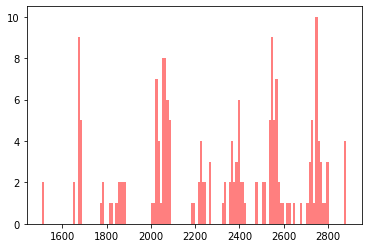

In [137]:
import matplotlib.pyplot as plt

cents_tolerance = 10

ref_hz = 55

main_pitch_in_hz = calc_hz(main_pitch_in_cents, ref_hz)

intervals = [[], [], []]
all_intervals = []

intervals_as_ji = dict()

cents_list = [[], [], []]
all_cents_list = []

all_chords = []
for chord in chords:
    pitches = chord.tony
    pitches_for_diff = []
    pitches_in_hz = []
    pitches_in_cents = []
    pitches_in_cents_with_none = []
    for p_idx, pitch in enumerate(pitches):
        if pitch is None:
            pitches_in_cents_with_none.append(None)
            continue
        cents_list[p_idx].append(pitch)
        all_cents_list.append(pitch)
        pitches_for_diff.append(pitch)
        pitch_in_hz = calc_hz(pitch, main_pitch_in_hz)
        pitches_in_hz.append(pitch_in_hz / main_pitch_in_hz)
        pitch_in_cents = int(ratio_to_cents(pitch_in_hz, main_pitch_in_hz))
        pitches_in_cents.append(pitch_in_cents)
        pitches_in_cents_with_none.append(pitch_in_cents)

    # chord intervals
    if len(pitches_for_diff) == 1:
        diffs = []
    elif len(pitches_for_diff) == 2:
        diffs = [pitches_for_diff[1] - pitches_for_diff[0]]
    else:
        diffs = [pitches_for_diff[2] - pitches_for_diff[0],
                 pitches_for_diff[2] - pitches_for_diff[1],
                 pitches_for_diff[1] - pitches_for_diff[0]]
        for k in range(3):
            intervals[k].append(diffs[k])
            all_intervals.append(diffs[k])
        ch = tuple(diffs)
        all_chords.append(ch)

    diffs = [abs(c) for c in diffs]
    notes = []
    for i, p in enumerate(diffs):
        n = str(diffs[i]) + 'c'
        state = ''
        for r in ratios:
            c1 = diffs[i]
            c2 = ratio_to_cents(r[0], r[1])
            check1 = abs(c1 - c2) < cents_tolerance
            check2 = abs(c1 - c2) < cents_tolerance * 1.5
            add = ''
            if check2 and not check1:
                add = '?'
            if check2:
                if r == (1, 1):
                    state = '.' + add
                else:
                    state = 'ji'
                    n += ' ' + add + str(r[0]) + '/' + str(r[1])
        notes.append((n, state))

    if len(diffs) == 3:
        for k in range(3):
            pretty = ' '.join(notes[k][0].split(' ')[1:])
            intervals_as_ji[diffs[k]] = pretty + ' ' + notes[k][1]

    
steps = [defaultdict(int), defaultdict(int), defaultdict(int)]
steps_list = [[], [], []]
all_steps = defaultdict(int)
all_steps_list = []
for voice in [0, 1, 2]:
    prev_pitch = None
    for chord in chords:
        cur_pitch = chord.tony[voice]
        if prev_pitch is not None and cur_pitch is not None:
            step = cur_pitch - prev_pitch
            if 0 < abs(step) < 210:
                steps[voice][abs(step)] += 1
                steps_list[voice].append(abs(step))
                all_steps[abs(step)] += 1
                all_steps_list.append(abs(step))
        prev_pitch = cur_pitch

%matplotlib inline
# 0: 2-0; 1: 2-1; 2: 1-0
datum = all_cents_list
datum = [x for x in datum if 1000 < x < 3000]
# print(sorted(datum))
num_bins = int((max(datum) - min(datum)) / 10)
# num_bins = 40
plt.hist(datum, num_bins,
         density=False,
         histtype='bar',
         facecolor='r',
         alpha=0.5)

32